In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from logger import logger
import os
import cv2
%matplotlib inline
np.random.seed(0)
tf.set_random_seed(0)

In [2]:
train = np.load('./data/train/train_dataset.npy')
labels = np.load('./data/train/labels.npy')

In [3]:
# Scaling data to standard mean and variance.
scaler0 = StandardScaler()
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()

train[:,:,:,0] = scaler0.fit_transform(train[:,:,:,0].reshape(-1,1)).reshape(-1,75,75)
train[:,:,:,1] = scaler1.fit_transform(train[:,:,:,1].reshape(-1,1)).reshape(-1,75,75)
train[:,:,:,2] = scaler2.fit_transform(train[:,:,:,2].reshape(-1,1)).reshape(-1,75,75)
train[:,:,:,3] = scaler3.fit_transform(train[:,:,:,3].reshape(-1,1)).reshape(-1,75,75)

print train.shape
#new_labels = np.zeros([labels.shape[0], 2])
#for i,ii in enumerate(labels):
#    if ii[0] == 0 : 
#        new_labels[i,0] = 1
#    else :
#        new_labels[i,1] = 1
#print new_labels.shape

(1604, 75, 75, 4)


In [27]:
if 1 :
    test_dataset = np.load('./data/test/test_dataset.npy')
    test_ids = np.load('./data/test/ids.npy')

    test_dataset[:,:,:,0] = scaler0.transform(test_dataset[:,:,:,0].reshape(-1,1)).reshape(-1,75,75)
    test_dataset[:,:,:,1] = scaler1.transform(test_dataset[:,:,:,1].reshape(-1,1)).reshape(-1,75,75)
    test_dataset[:,:,:,2] = scaler2.transform(test_dataset[:,:,:,2].reshape(-1,1)).reshape(-1,75,75)
    test_dataset[:,:,:,3] = scaler3.transform(test_dataset[:,:,:,3].reshape(-1,1)).reshape(-1,75,75)
    
    #test_dataset = test_dataset[:,:,:,2:4]
    print test_dataset.shape

(8424, 75, 75, 4)


In [6]:
# DATA augmentation. from kerenel, https://www.kaggle.com/vincento/keras-starter-4l-0-1936-lb-icebergchallenge/code
def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        d=imgs[i,:,:,3]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        dv=cv2.flip(d,1)
        dh=cv2.flip(d,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv, dv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch, dh)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

train = get_more_images(train)
labels = np.concatenate((labels,labels,labels))
print train.shape
print labels.shape

(4812, 75, 75, 4)
(4812, 1)


4812

In [7]:
# getting validation set
train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(train, labels, test_size=.1)


print train_dataset.shape, train_labels.shape
print valid_dataset.shape, valid_labels.shape

del train, labels

(4330, 75, 75, 4) (4330, 1)
(482, 75, 75, 4) (482, 1)


------------------------

 ** An iceberg


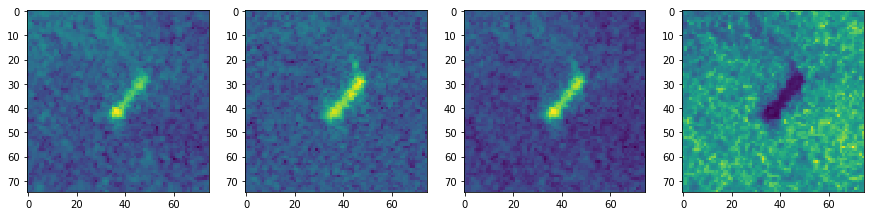

In [11]:
plt.rcParams["figure.figsize"] = [15,15]
index = np.random.randint(0, train_dataset.shape[0])
f, axarr = plt.subplots(1,4)
_ = axarr[0].imshow(train_dataset[index,:,:,0])
_ = axarr[1].imshow(train_dataset[index,:,:,1])
_ = axarr[2].imshow(train_dataset[index,:,:,2])
_ = axarr[3].imshow(train_dataset[index,:,:,3])

print " ** A ship" if train_labels[index,0] == 1 else " ** An iceberg"

In [ ]:
#train_dataset = train_dataset[:,:,:,2:4]
#valid_dataset = valid_dataset[:,:,:,2:4]


In [12]:
def extract_batch(i):
    
    start_idx = (i * batch_size) % (train_dataset.shape[0] - batch_size )
    end_idx = start_idx + batch_size
    batch_data = train_dataset[ start_idx : end_idx ]
    batch_labels = train_labels[ start_idx : end_idx ]
    
    return batch_data, batch_labels.astype(np.float32)

In [13]:
def create_placeholders(n_H, n_W, n_C, n_y, name1='X', name2='Y'):
    '''
    Create X and Y placeholder, ready for each minibatch
    input : 
        n_H : height of input image
        n_W : width of input image
        n_C : number of channels per image
        n_y  : number of classes
    '''
    X = tf.placeholder(tf.float32, [None, n_H, n_W, n_C], name1)
    Y = tf.placeholder(tf.float32, [None, n_y], name2)
    
    return X,Y

In [14]:
def initialize_parameters(weight_shape, bias_shape=None):
    W = tf.get_variable("W", weight_shape, initializer=tf.contrib.layers.xavier_initializer(seed=0))
    return W, None

In [15]:
def convolution_layer(input_, training,
                      filters, kernel_size, conv_strides, 
                      pool_size, pool_strides,
                      dropout_rate) :
    
    with tf.variable_scope('conv_layer'):
                
        Z = tf.layers.conv2d(input_, filters, kernel_size, conv_strides, 'SAME', activation=tf.nn.relu)
        
        Z = tf.layers.batch_normalization(Z)
        
        Z = tf.layers.max_pooling2d(Z, pool_size, pool_strides, 'SAME')
        
        Z = tf.layers.dropout(Z, dropout_rate, training=training)
   
    return Z

In [16]:
def inference(X, training=True):
    
    with tf.variable_scope("layer_1"):
        L =  convolution_layer(X, training, filters=64, kernel_size=3, conv_strides=1,
                                pool_size=3, pool_strides=2, dropout_rate=.2)
                            
    with tf.variable_scope("layer_2"):
        L =  convolution_layer(L, training, filters=128, kernel_size=2, conv_strides=1, 
                                pool_size=3, pool_strides=2, dropout_rate=.2)
    
    with tf.variable_scope("layer_3"):
        L =  convolution_layer(L, training, filters=128, kernel_size=2, conv_strides=1, 
                                pool_size=2, pool_strides=2, dropout_rate=.2)
    
    with tf.variable_scope("layer_4"):
        L =  convolution_layer(L, training, filters=128, kernel_size=2, conv_strides=1,
                                pool_size=2, pool_strides=2, dropout_rate=.2)
    
    with tf.variable_scope("layer_5"):
        # FC layer
        L = tf.contrib.layers.flatten(L)
        L = tf.contrib.layers.fully_connected(L,1024, activation_fn=tf.nn.relu)
        L = tf.layers.batch_normalization(L)
        # dropout layer
        L = tf.layers.dropout(L, rate=.2, training=training)
        
    with tf.variable_scope("layer_6"):
        # FC layer
        L = tf.contrib.layers.fully_connected(L, 512, activation_fn=tf.nn.relu)
        L = tf.layers.batch_normalization(L)
        # dropout layer
        L = tf.layers.dropout(L, rate=.2, training=training)
    
    with tf.variable_scope("layer_7"):
        # FC layer
        L = tf.contrib.layers.fully_connected(L, 256, activation_fn=tf.nn.relu)
        L = tf.layers.batch_normalization(L)
        # dropout layer
        L = tf.layers.dropout(L, rate=.2, training=training)
    
    with tf.variable_scope("layer_8"):
        # FC layer
        L = tf.contrib.layers.fully_connected(L, 32, activation_fn=tf.nn.relu)
        L = tf.layers.batch_normalization(L)
        # dropout layer
        L = tf.layers.dropout(L, rate=.2, training=training)
        
    with tf.variable_scope("layer_9"):
        # FC layer
        L = tf.contrib.layers.fully_connected(L, 1, activation_fn=None)
        print L
    return L

In [17]:
def compute_loss(Z, Y):
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z, labels=Y))
    return loss

In [18]:
def optimize(loss, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(loss, global_step=global_step) 
    return optimizer

In [19]:
def get_summary(loss, tf_valid_loss):
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('valid_loss', tf_valid_loss)
    return tf.summary.merge_all()

In [39]:
def predict_test():
    f = open('./data/submissiontest.csv', 'wb')
    f.write('id,is_iceberg\n')
    print "\npredicting test dataset"
    step = 200
    n_steps = test_dataset.shape[0] / step
    all_p = None
    for sind in range(0,test_dataset.shape[0], step) :
        print "step", sind/step, 'of', n_steps, '....'
        #-----------------------------------
        eind = sind + step
        if eind > test_dataset.shape[0] :
            eind = test_dataset.shape[0]
         #--------------------------------------
        test_pred = sess.run(tf_test_pred, feed_dict={X_test : test_dataset[sind:eind]})
        try :
            all_p = np.concatenate((all_p,test_pred),axis=0)
        except :
            all_p = test_pred
        print all_p.shape
        for e1, e2 in zip(test_ids[sind:eind], test_pred):
            f.write('{},{}\n'.format(e1,e2[0]))
    f.close()
    print "finished predicting\n"
    return

In [40]:
# Defining Model graph :
learning_rate = 0.001
n_H, n_W, n_C = train_dataset.shape[1:]
n_y = train_labels.shape[1]

graph = tf.Graph()
with graph.as_default():
    
    with tf.variable_scope('input_data'):
        X, Y = create_placeholders(n_H, n_W, n_C, n_y)
        X_valid, Y_valid = create_placeholders(n_H, n_W, n_C, n_y, 'X_valid', 'Y_valid')
        X_test = tf.placeholder(tf.float32, [None, n_H, n_W, n_C], name='X_test')
        
    with tf.variable_scope('forward_propogation', reuse=tf.AUTO_REUSE):
        Z = inference(X)
        Z_valid = inference(X_valid, training=False)
        Z_test = inference(X_test, training=False)
    
    with tf.variable_scope('loss'):
        tf_loss = compute_loss(Z, Y)
        tf_loss_valid = compute_loss(Z_valid, Y_valid)
    
    with tf.variable_scope('training'):
        global_step = tf.Variable(0, name='global_step',trainable=False)
        optimizer = optimize(tf_loss, global_step)
    
    with tf.variable_scope('summary'):
        summary_writer = tf.summary.FileWriter('./tmp/logs/', graph)
        summary = get_summary(tf_loss, tf_loss_valid)
    
    with tf.variable_scope('model_saver'):
        saver = tf.train.Saver()
    
    with tf.variable_scope('test_predictions'):
        tf_test_pred = tf.sigmoid(Z_test)
    

Tensor("forward_propogation/layer_9/fully_connected/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("forward_propogation/layer_9_1/fully_connected/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("forward_propogation/layer_9_2/fully_connected/BiasAdd:0", shape=(?, 1), dtype=float32)


In [22]:
# defining Session to run all the above.
# displaying paramters
avg_loss = 0
avg_valid_loss = 0
display_step = 20
#----------------------------
saving_step = 50
batch_size = 32
epoches = 4000
# early stopping parameters
best_loss = 999
ESRounds = 500
rounds = 0
#----------------------------
# intialize logfile
logging = True
if logging : 
    files = 
    file_index = sorted([int(f.split('.')[0]) for f in os.listdir('./tmp/onrun-log/')])[-1] + 1
    log = logger('{}.log'.format(file_index), log_dir='./tmp/onrun-log/')
    log.add("epoches = {}, batch_size = {}, ESRounds = {}, training shape = {}, validation shape = {},"
            " Run on {}\n------"\
            .format(epoches,batch_size,ESRounds,train_dataset.shape,valid_dataset.shape,np.datetime64('now')))
    print "Log file is ready."
#------------------------------
with tf.Session(graph=graph) as sess:
    
    tf.global_variables_initializer().run()

    #summary_writer = tf.summary.FileWriter('./tmp/logs/', sess.graph)
    
    for i in range(epoches):
        
        batch_data, batch_labels = extract_batch(i)
        feed_dict = { X : batch_data, Y : batch_labels, X_valid : valid_dataset, Y_valid : valid_labels }
        _, l, valid_loss = sess.run([optimizer, tf_loss, tf_loss_valid], feed_dict=feed_dict)
        avg_loss += l
        avg_valid_loss += valid_loss
        
        # Print loss after each N display steps, also add summary to file.
        if i % display_step == 0 :
            avg_loss /= display_step
            avg_valid_loss /= display_step
            #feed_dict[X_valid] = valid_dataset
            #feed_dict[Y_valid] = valid_labels
            #summary_str = sess.run(summary, feed_dict=feed_dict)
            #_ = summary_writer.add_summary(summary_str, sess.run(global_step))
           
            print "Finished {} steps [{:.3g}%],\t loss : {},\t valid loss : {} "\
                               .format(i,1.*i*batch_size/train_dataset.shape[0],avg_loss,avg_valid_loss)
            if logging : log.add("Finished {} steps [{:.3g}%],\t loss : {},\t valid loss : {} "\
                               .format(i,1.*i*batch_size/train_dataset.shape[0],avg_loss,avg_valid_loss))
            avg_loss = 0
            avg_valid_loss = 0
            
        # ADD early stopping Step.
        if valid_loss < best_loss :
            print "New best loss : {}, on round : {} and step : {}".format(valid_loss,rounds,i)
            log.add("New best loss : {}, on round : {} and step : {}".format(valid_loss,rounds,i))
            best_loss = valid_loss
            rounds = 0
            _ = saver.save(sess, './tmp/model_checkpoints/model-ckpt-best')
        else :
            if rounds == ESRounds :
                print "reached the specified early stopping rounds [{}]\n.Stopping Model.".format(ESRounds)
                if logging : log.add("reached the specified early stopping rounds [{}]\n.Stopping Model."\
                                     .format(ESRounds))
                summary_writer.close()
                break
            rounds += 1
        
        #if i % saving_step == 0 and i > 0:
        #    print "Saving model"
        #    _ = saver.save(sess, './tmp/model_checkpoints/model-checkpoint', global_step=global_step)
    # predict test_data
    #predict_test()
    summary_writer.close()

    

Log file is ready.
Finished 0 steps [0%],	 loss : 0.0395309507847,	 valid loss : 0.0388387709856 
New best loss : 0.776775419712, on round : 0 and step : 0
New best loss : 0.691892147064, on round : 1 and step : 2
New best loss : 0.686667025089, on round : 0 and step : 3
New best loss : 0.686002969742, on round : 0 and step : 4
New best loss : 0.685811698437, on round : 0 and step : 5
New best loss : 0.685375511646, on round : 0 and step : 6
New best loss : 0.684575378895, on round : 7 and step : 14
New best loss : 0.684372663498, on round : 0 and step : 15
New best loss : 0.683394789696, on round : 0 and step : 16
New best loss : 0.681376218796, on round : 0 and step : 17
New best loss : 0.677731633186, on round : 0 and step : 18
New best loss : 0.672299802303, on round : 0 and step : 19
Finished 20 steps [0.148%],	 loss : 0.741118574142,	 valid loss : 0.690743878484 
New best loss : 0.667698919773, on round : 0 and step : 20
New best loss : 0.662531137466, on round : 0 and step : 21


Finished 660 steps [4.88%],	 loss : 0.302602028847,	 valid loss : 0.290456110239 
Finished 680 steps [5.03%],	 loss : 0.316774784029,	 valid loss : 0.29632730633 
New best loss : 0.253379583359, on round : 114 and step : 680
New best loss : 0.249052718282, on round : 18 and step : 699
Finished 700 steps [5.17%],	 loss : 0.269052353129,	 valid loss : 0.283311278373 
Finished 720 steps [5.32%],	 loss : 0.277604892105,	 valid loss : 0.271500366926 
Finished 740 steps [5.47%],	 loss : 0.332903020084,	 valid loss : 0.296101654321 
New best loss : 0.246475890279, on round : 40 and step : 740
Finished 760 steps [5.62%],	 loss : 0.27382279709,	 valid loss : 0.281803128123 
Finished 780 steps [5.76%],	 loss : 0.369161447883,	 valid loss : 0.347819785774 
Finished 800 steps [5.91%],	 loss : 0.286946829408,	 valid loss : 0.269031588733 
Finished 820 steps [6.06%],	 loss : 0.34157468304,	 valid loss : 0.28492693156 
New best loss : 0.24280449748, on round : 82 and step : 823
New best loss : 0.2345

Finished 2120 steps [15.7%],	 loss : 0.165399699286,	 valid loss : 0.227333339304 
Finished 2140 steps [15.8%],	 loss : 0.204426064715,	 valid loss : 0.216369184107 
Finished 2160 steps [16%],	 loss : 0.192197040468,	 valid loss : 0.208739805222 
Finished 2180 steps [16.1%],	 loss : 0.160289748944,	 valid loss : 0.227105138451 
Finished 2200 steps [16.3%],	 loss : 0.178188779205,	 valid loss : 0.205808071047 
Finished 2220 steps [16.4%],	 loss : 0.204560061358,	 valid loss : 0.200890463591 
Finished 2240 steps [16.6%],	 loss : 0.188542878069,	 valid loss : 0.220581834763 
Finished 2260 steps [16.7%],	 loss : 0.170156796835,	 valid loss : 0.200893380493 
Finished 2280 steps [16.8%],	 loss : 0.197177707218,	 valid loss : 0.20447846204 
Finished 2300 steps [17%],	 loss : 0.158990406245,	 valid loss : 0.232624186575 
New best loss : 0.170780211687, on round : 438 and step : 2316
Finished 2320 steps [17.1%],	 loss : 0.14178096801,	 valid loss : 0.188956709206 
New best loss : 0.170771554112

In [ ]:
train_dataset = train_dataset[:,:,:,2:4].reshape(-1,75,75,2)
valid_dataset = valid_dataset[:,:,:,2:4].reshape(-1,75,75,2)

In [41]:
with tf.Session(graph=graph) as sess :
    _ = saver.restore(sess, './tmp/model_checkpoints/model-ckpt-best')
    valid_loss = sess.run(tf_loss_valid, {X_valid:valid_dataset, Y_valid:valid_labels})
    print valid_loss
    predict_test()

INFO:tensorflow:Restoring parameters from ./tmp/model_checkpoints/model-ckpt-best
0.165863

predicting test dataset
step 0 of 42 ....
(200, 1)
step 1 of 42 ....
(400, 1)
step 2 of 42 ....
(600, 1)
step 3 of 42 ....
(800, 1)
step 4 of 42 ....


KeyboardInterrupt: 

In [ ]:
summary_writer.add_summary(summary_str)

In [37]:
v = None